1. ✅ **Use 5-point central difference** → to compute velocity & acceleration manually (not directly from MediaPipe).
2. ✅ **Use time (seconds) as X-axis** instead of frame numbers.
3. ✅ **Confirm FPS from video** (used dynamically for all timing & derivatives).
4. ✅ **Auto-segment exercise repetitions** using elbow-angle peaks/troughs.
5. ✅ **Align displacement, velocity & acceleration plots** on the same time axis with rep markers.
6. ✅ **Perform FFT on displacement** to find dominant motion frequency.
7. ✅ **Design adaptive Butterworth low-pass filter** (cutoff ≈ 1.05× dominant frequency).
8. ✅ **Filter displacement, then derive velocity & acceleration** from the smoothed signal.
9. ✅ **Compare before-vs-after filtering plots** to show improvement.
10. ✅ **Save full processed dataset & per-rep summary** to Excel for analysis.

Prev review

In [ ]:
!pip install mediapipe opencv-python-headless pandas matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 6.3 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of opencv-python-headless to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of opencv-contrib-python to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 54.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 MB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 92.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 10.4 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
  Attempting uninstall: numpy
    Found exi

📂 Please upload your exercise video (e.g., pull_up_1.mp4):


Saving pull up_11.mp4 to pull up_11.mp4
✅ Using uploaded file: pull up_11.mp4
✅ Data saved to pull up_11_full_analysis.xlsx


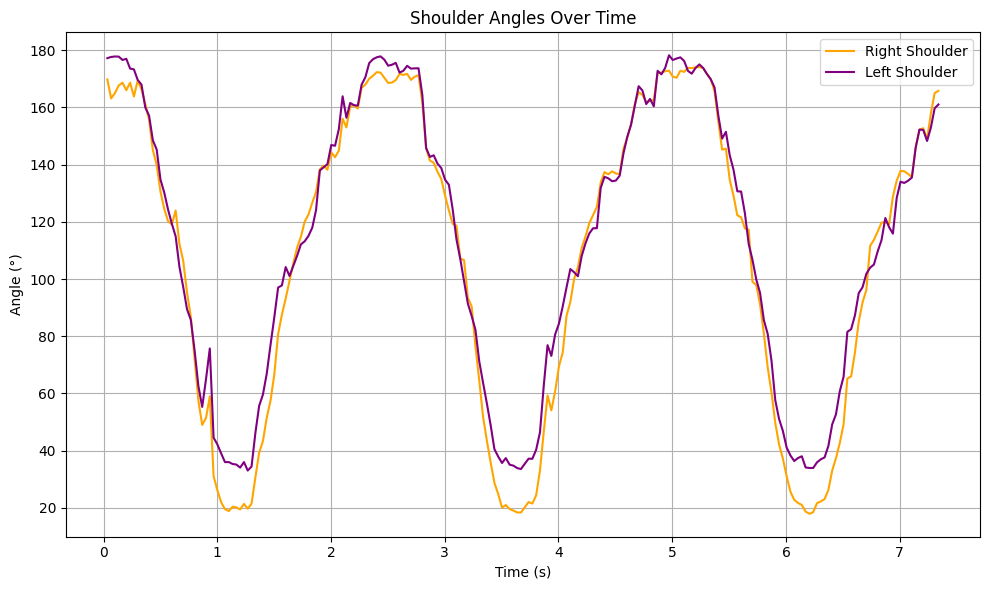

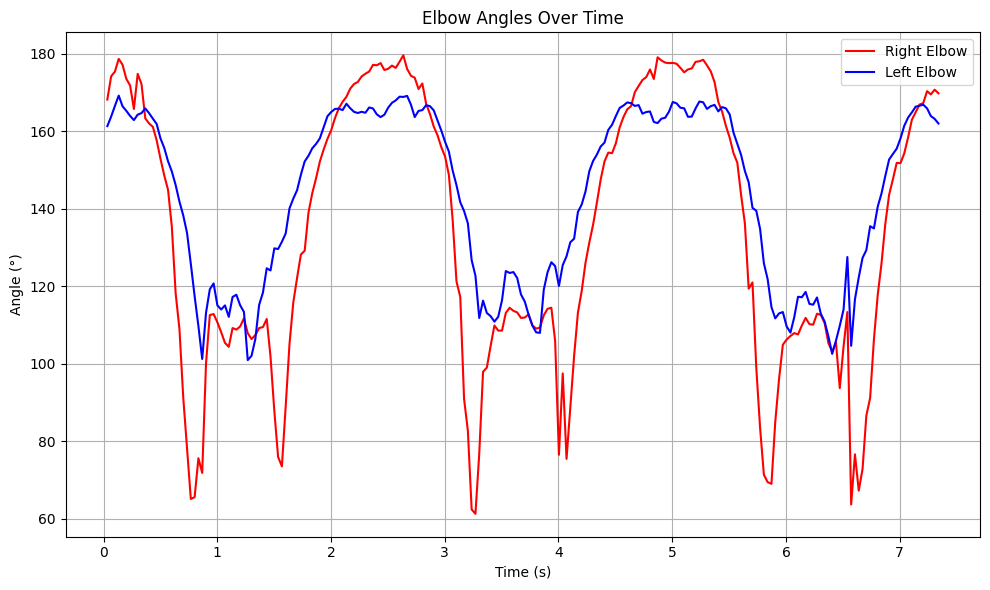

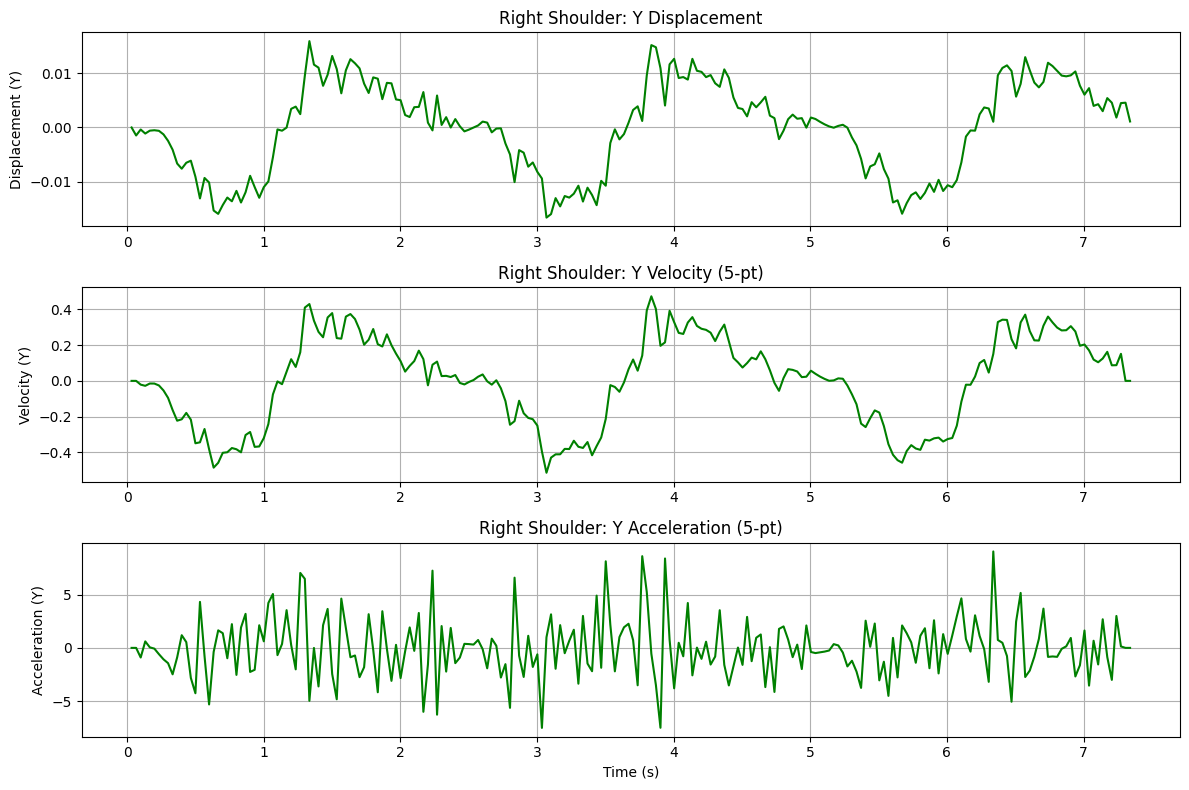

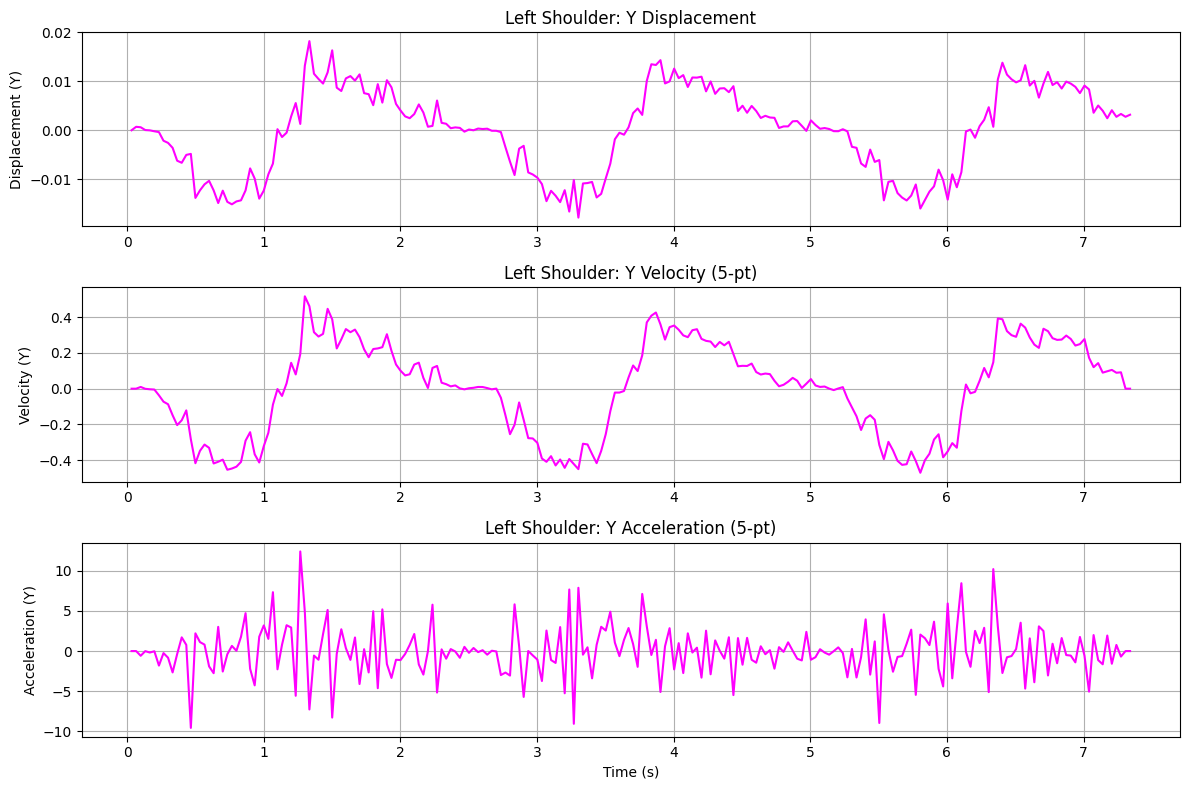

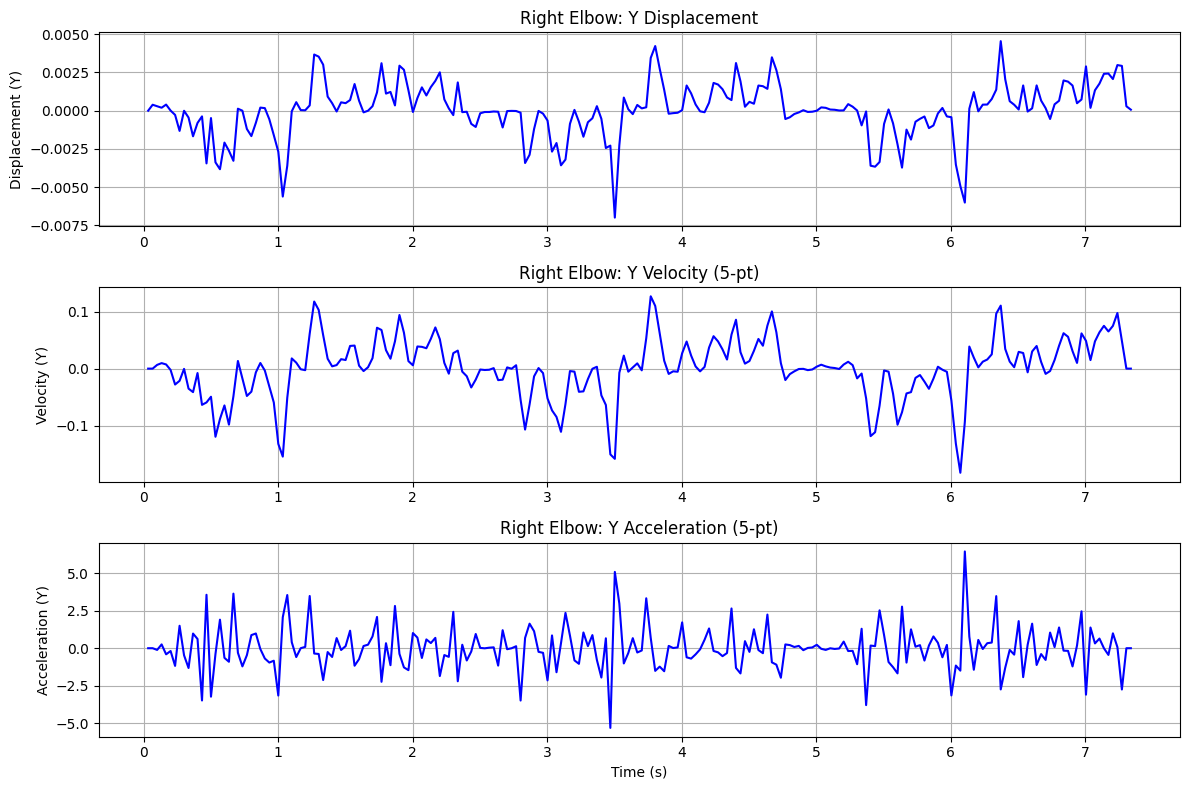

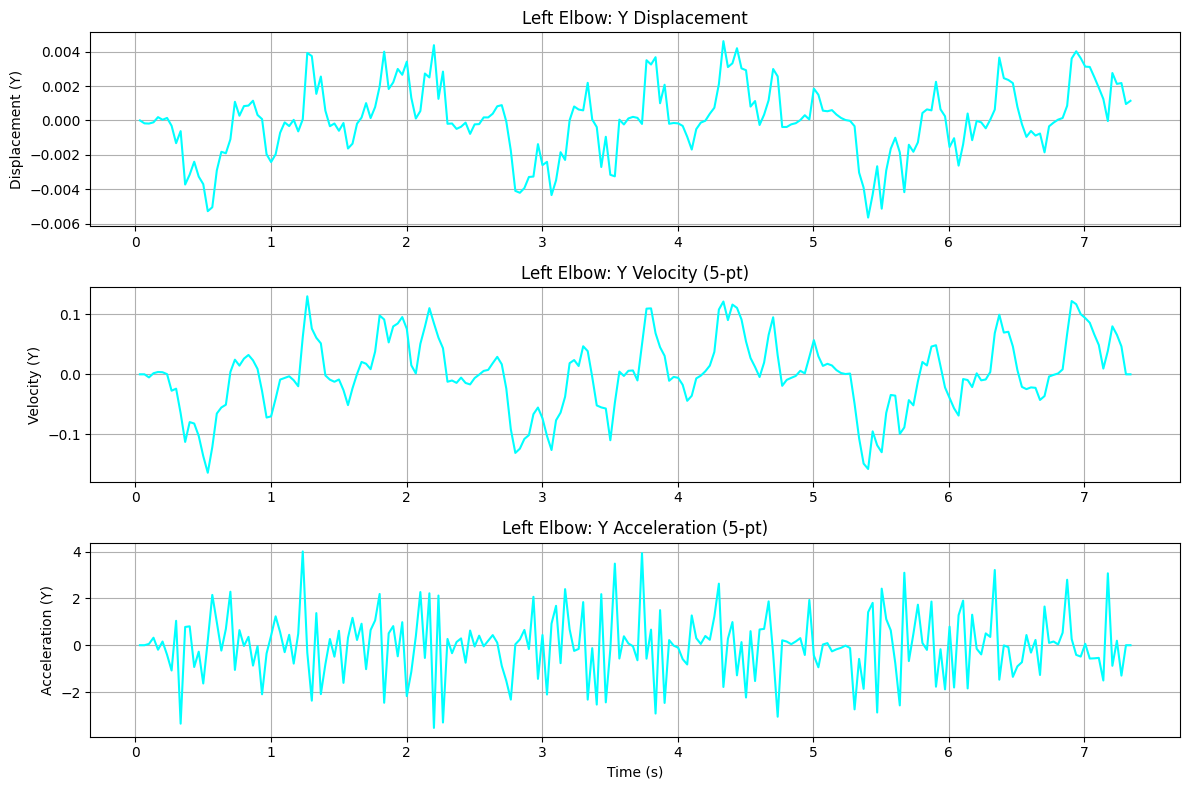

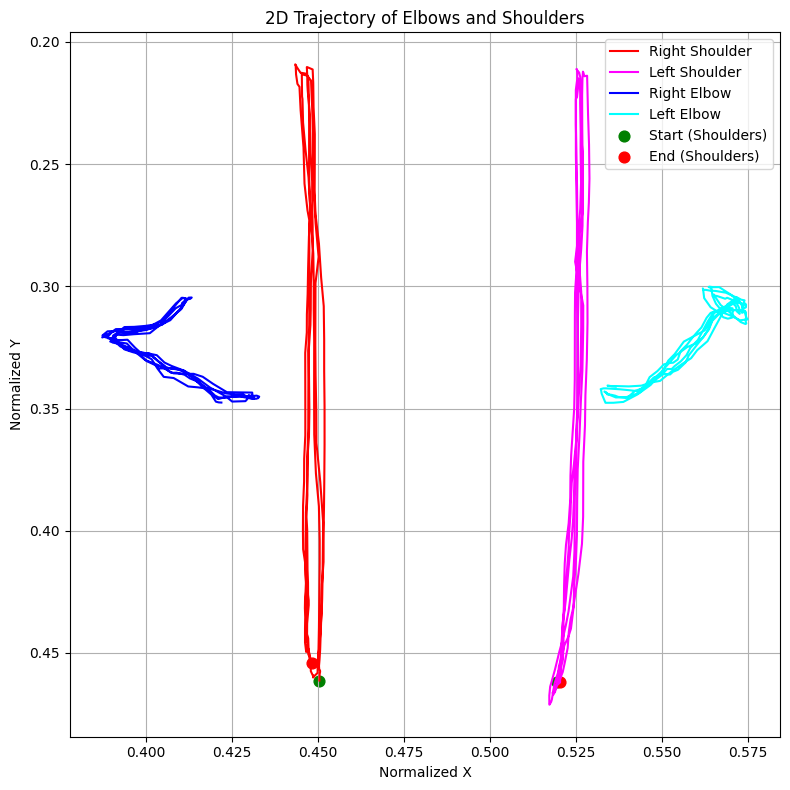

⬇️ Downloading Excel file...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# --- IMPORTS ---
from google.colab import files
import cv2
import mediapipe as mp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# --- UPLOAD VIDEO FILE ---
print("📂 Please upload your exercise video (e.g., pull_up_1.mp4):")
uploaded = files.upload()

# Get the uploaded file path
VIDEO_PATH = list(uploaded.keys())[0]
print(f"✅ Using uploaded file: {VIDEO_PATH}")

# --- OUTPUT PATH ---
base_name = os.path.splitext(VIDEO_PATH)[0]
OUTPUT_XLSX = f"{base_name}_full_analysis.xlsx"

# --- POSE SETUP ---
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False,
                    min_detection_confidence=0.5,
                    min_tracking_confidence=0.5)

# --- ANGLE FUNCTION ---
def calculate_angle(a, b, c):
    a, b, c = np.array(a), np.array(b), np.array(c)
    ba, bc = a - b, c - b
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(np.clip(cosine_angle, -1.0, 1.0))
    return np.degrees(angle)

# --- DATA EXTRACTION ---
cap = cv2.VideoCapture(VIDEO_PATH)
fps = cap.get(cv2.CAP_PROP_FPS)
frame_num = 0
data = []

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    frame_num += 1
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = pose.process(rgb)

    if results.pose_landmarks:
        lmarks = results.pose_landmarks.landmark
        row = [frame_num]
        for lm in lmarks:
            row.extend([lm.x, lm.y, lm.z])

        # --- JOINT ANGLES ---
        # Elbows
        right_elbow_angle = calculate_angle(
            [lmarks[12].x, lmarks[12].y, lmarks[12].z],
            [lmarks[14].x, lmarks[14].y, lmarks[14].z],
            [lmarks[16].x, lmarks[16].y, lmarks[16].z])
        left_elbow_angle = calculate_angle(
            [lmarks[11].x, lmarks[11].y, lmarks[11].z],
            [lmarks[13].x, lmarks[13].y, lmarks[13].z],
            [lmarks[15].x, lmarks[15].y, lmarks[15].z])

        # Shoulders
        right_shoulder_angle = calculate_angle(
            [lmarks[24].x, lmarks[24].y, lmarks[24].z],
            [lmarks[12].x, lmarks[12].y, lmarks[12].z],
            [lmarks[14].x, lmarks[14].y, lmarks[14].z])
        left_shoulder_angle = calculate_angle(
            [lmarks[23].x, lmarks[23].y, lmarks[23].z],
            [lmarks[11].x, lmarks[11].y, lmarks[11].z],
            [lmarks[13].x, lmarks[13].y, lmarks[13].z])

        row.extend([right_elbow_angle, left_elbow_angle,
                    right_shoulder_angle, left_shoulder_angle])
        data.append(row)

cap.release()
pose.close()

# --- DATAFRAME SETUP ---
columns = ['frame']
for i in range(33):
    columns += [f'lm{i}_x', f'lm{i}_y', f'lm{i}_z']
columns += ['right_elbow_angle', 'left_elbow_angle',
            'right_shoulder_angle', 'left_shoulder_angle']
df = pd.DataFrame(data, columns=columns)

# --- TIME AXIS ---
df['time_s'] = df['frame'] / fps

# --- OPTIONAL: CORRECT LEFT/RIGHT SWAPS ---
def correct_symmetric_swaps(df, left_idx, right_idx, prefix='lm'):
    for idx in range(1, len(df)):
        prev_r = np.array([df.loc[idx-1, f'{prefix}{right_idx}_x'],
                           df.loc[idx-1, f'{prefix}{right_idx}_y']])
        prev_l = np.array([df.loc[idx-1, f'{prefix}{left_idx}_x'],
                           df.loc[idx-1, f'{prefix}{left_idx}_y']])
        curr_r = np.array([df.loc[idx, f'{prefix}{right_idx}_x'],
                           df.loc[idx, f'{prefix}{right_idx}_y']])
        curr_l = np.array([df.loc[idx, f'{prefix}{left_idx}_x'],
                           df.loc[idx, f'{prefix}{left_idx}_y']])
        d_rr = np.linalg.norm(curr_r - prev_r)
        d_rl = np.linalg.norm(curr_l - prev_r)
        d_ll = np.linalg.norm(curr_l - prev_l)
        d_lr = np.linalg.norm(curr_r - prev_l)
        if d_rl < d_rr and d_lr < d_ll:
            for axis in ['x', 'y']:
                temp = df.loc[idx, f'{prefix}{right_idx}_{axis}']
                df.loc[idx, f'{prefix}{right_idx}_{axis}'] = df.loc[idx, f'{prefix}{left_idx}_{axis}']
                df.loc[idx, f'{prefix}{left_idx}_{axis}'] = temp

correct_symmetric_swaps(df, left_idx=13, right_idx=14, prefix='lm')  # elbows
correct_symmetric_swaps(df, left_idx=11, right_idx=12, prefix='lm')  # shoulders

# --- KINEMATICS (DISPLACEMENT / VELOCITY / ACCELERATION) ---
h = 1.0 / fps
for joint in ['lm12', 'lm11', 'lm14', 'lm13']:
    df[f'{joint}_y_disp'] = df[f'{joint}_y'].diff().fillna(0)
    df[f'{joint}_y_v'] = (
        -df[f'{joint}_y'].shift(-2) + 8 * df[f'{joint}_y'].shift(-1)
        - 8 * df[f'{joint}_y'].shift(1) + df[f'{joint}_y'].shift(2)
    ) / (12 * h)
    df[f'{joint}_y_a'] = (
        -df[f'{joint}_y'].shift(-2)
        + 16 * df[f'{joint}_y'].shift(-1)
        - 30 * df[f'{joint}_y']
        + 16 * df[f'{joint}_y'].shift(1)
        - df[f'{joint}_y'].shift(2)
    ) / (12 * h ** 2)

df.fillna(0, inplace=True)

# --- SAVE TO EXCEL ---
df.to_excel(OUTPUT_XLSX, index=False)
print(f"✅ Data saved to {OUTPUT_XLSX}")

# --- PLOTS ---

# 1️⃣ Shoulder Angles
plt.figure(figsize=(10,6))
plt.plot(df['time_s'], df['right_shoulder_angle'], label='Right Shoulder', color='orange')
plt.plot(df['time_s'], df['left_shoulder_angle'], label='Left Shoulder', color='purple')
plt.xlabel('Time (s)')
plt.ylabel('Angle (°)')
plt.title('Shoulder Angles Over Time')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# 2️⃣ Elbow Angles
plt.figure(figsize=(10,6))
plt.plot(df['time_s'], df['right_elbow_angle'], label='Right Elbow', color='red')
plt.plot(df['time_s'], df['left_elbow_angle'], label='Left Elbow', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Angle (°)')
plt.title('Elbow Angles Over Time')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# 3️⃣ Kinematic Graphs
joint_names = {'lm12': 'Right Shoulder', 'lm11': 'Left Shoulder',
               'lm14': 'Right Elbow', 'lm13': 'Left Elbow'}
joint_colors = {'lm12': 'green', 'lm11': 'magenta',
                'lm14': 'blue', 'lm13': 'cyan'}

for joint in ['lm12', 'lm11', 'lm14', 'lm13']:
    plt.figure(figsize=(12,8))
    plt.subplot(3,1,1)
    plt.plot(df['time_s'], df[f'{joint}_y_disp'], color=joint_colors[joint])
    plt.ylabel('Displacement (Y)')
    plt.title(f'{joint_names[joint]}: Y Displacement')
    plt.grid()

    plt.subplot(3,1,2)
    plt.plot(df['time_s'], df[f'{joint}_y_v'], color=joint_colors[joint])
    plt.ylabel('Velocity (Y)')
    plt.title(f'{joint_names[joint]}: Y Velocity (5-pt)')
    plt.grid()

    plt.subplot(3,1,3)
    plt.plot(df['time_s'], df[f'{joint}_y_a'], color=joint_colors[joint])
    plt.xlabel('Time (s)')
    plt.ylabel('Acceleration (Y)')
    plt.title(f'{joint_names[joint]}: Y Acceleration (5-pt)')
    plt.grid()

    plt.tight_layout()
    plt.show()

# 4️⃣ 2D Trajectory (Elbows & Shoulders)
plt.figure(figsize=(8,8))
plt.plot(df['lm12_x'], df['lm12_y'], label='Right Shoulder', color='red')
plt.plot(df['lm11_x'], df['lm11_y'], label='Left Shoulder', color='magenta')
plt.plot(df['lm14_x'], df['lm14_y'], label='Right Elbow', color='blue')
plt.plot(df['lm13_x'], df['lm13_y'], label='Left Elbow', color='cyan')
plt.scatter([df['lm12_x'].iloc[0], df['lm11_x'].iloc[0]],
            [df['lm12_y'].iloc[0], df['lm11_y'].iloc[0]],
            color='green', s=60, label='Start (Shoulders)')
plt.scatter([df['lm12_x'].iloc[-1], df['lm11_x'].iloc[-1]],
            [df['lm12_y'].iloc[-1], df['lm11_y'].iloc[-1]],
            color='red', s=60, label='End (Shoulders)')
plt.gca().invert_yaxis()
plt.xlabel('Normalized X')
plt.ylabel('Normalized Y')
plt.title('2D Trajectory of Elbows and Shoulders')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# --- DOWNLOAD OUTPUT ---
print("⬇️ Downloading Excel file...")
files.download(OUTPUT_XLSX)


changes part 1


*   Extracted FPS for accurate time axis.
*   Calculated displacement, velocity, acceleration using formulas.
*   Converted normalized to pixel coordinates.
*   Aligned disp, vel, acc plots on common time axis.
* Added automatic repetition detection and marking.
* Generated per-rep summary (duration, ROM, peaks).
* Enhanced plots with rep markings.
* Saved full dataset and summary to Excel.
* Printed key metrics (FPS, frame size, rep table).



📂 Please upload your exercise video (e.g., pull_up_1.mp4):


Saving pull up_11.mp4 to pull up_11 (1).mp4
✅ Using uploaded file: pull up_11 (1).mp4
Detected FPS: 29.97002997002997, Frame size: 1280x720
✅ Saved: pull up_11 (1)_full_data.xlsx (frame-wise) and pull up_11 (1)_rep_summary.xlsx (per-rep summary)


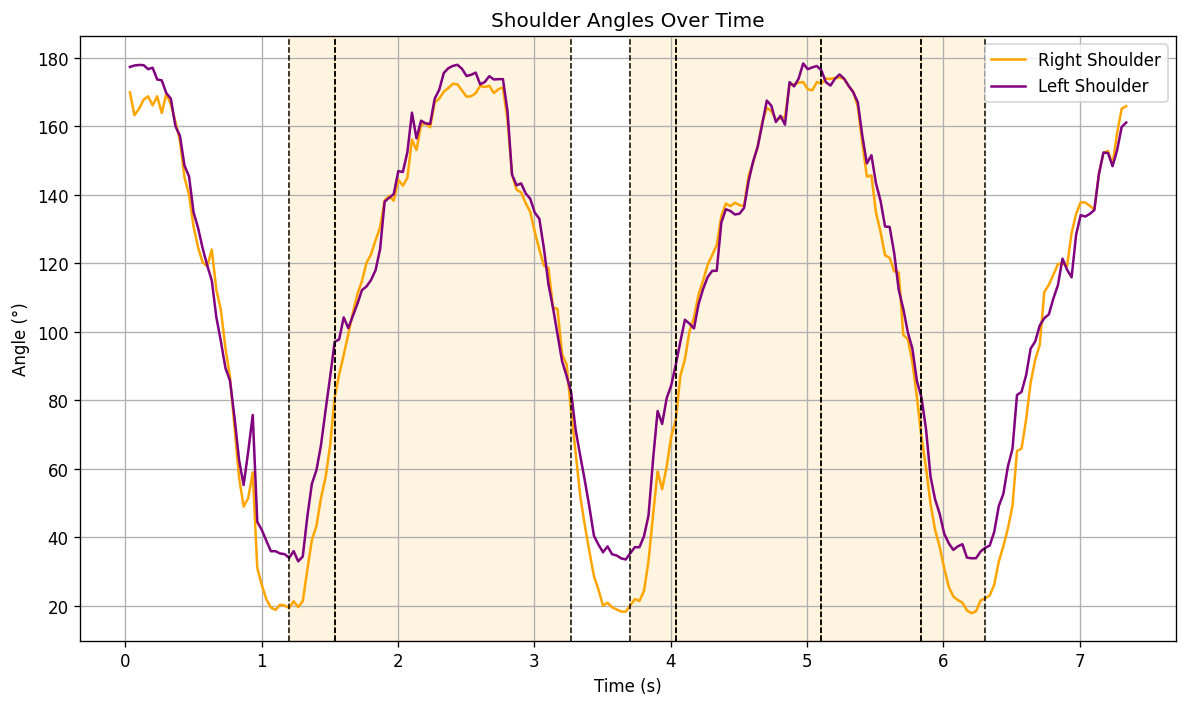

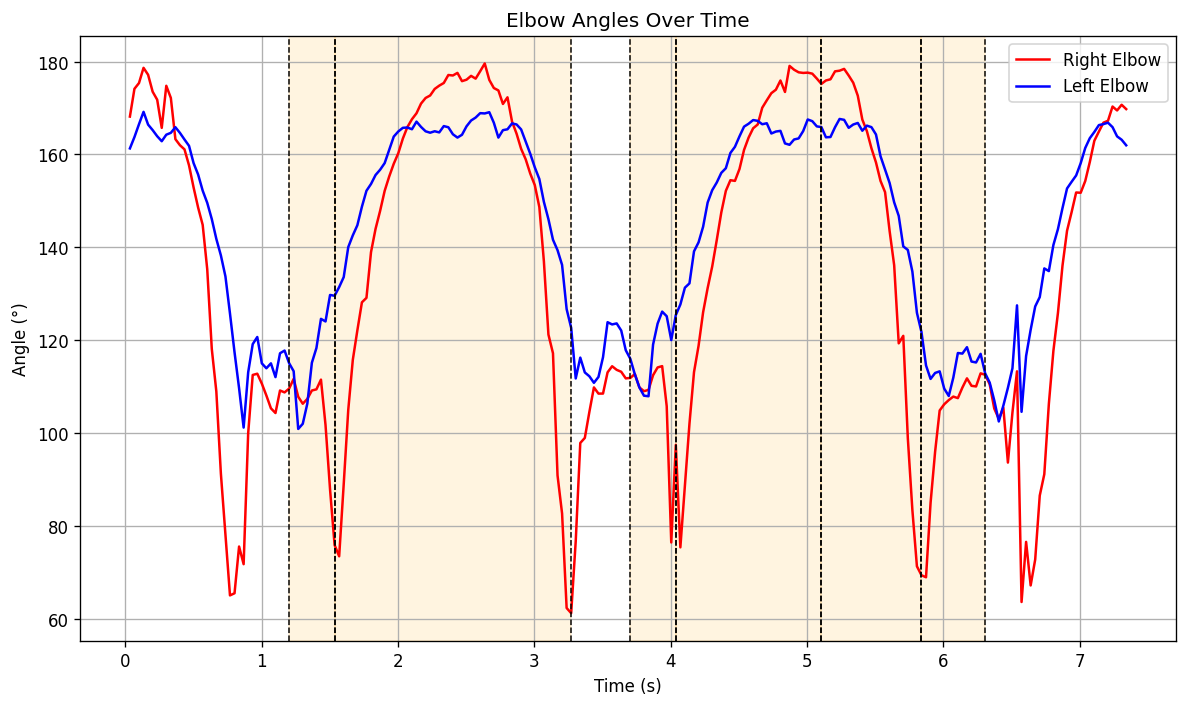

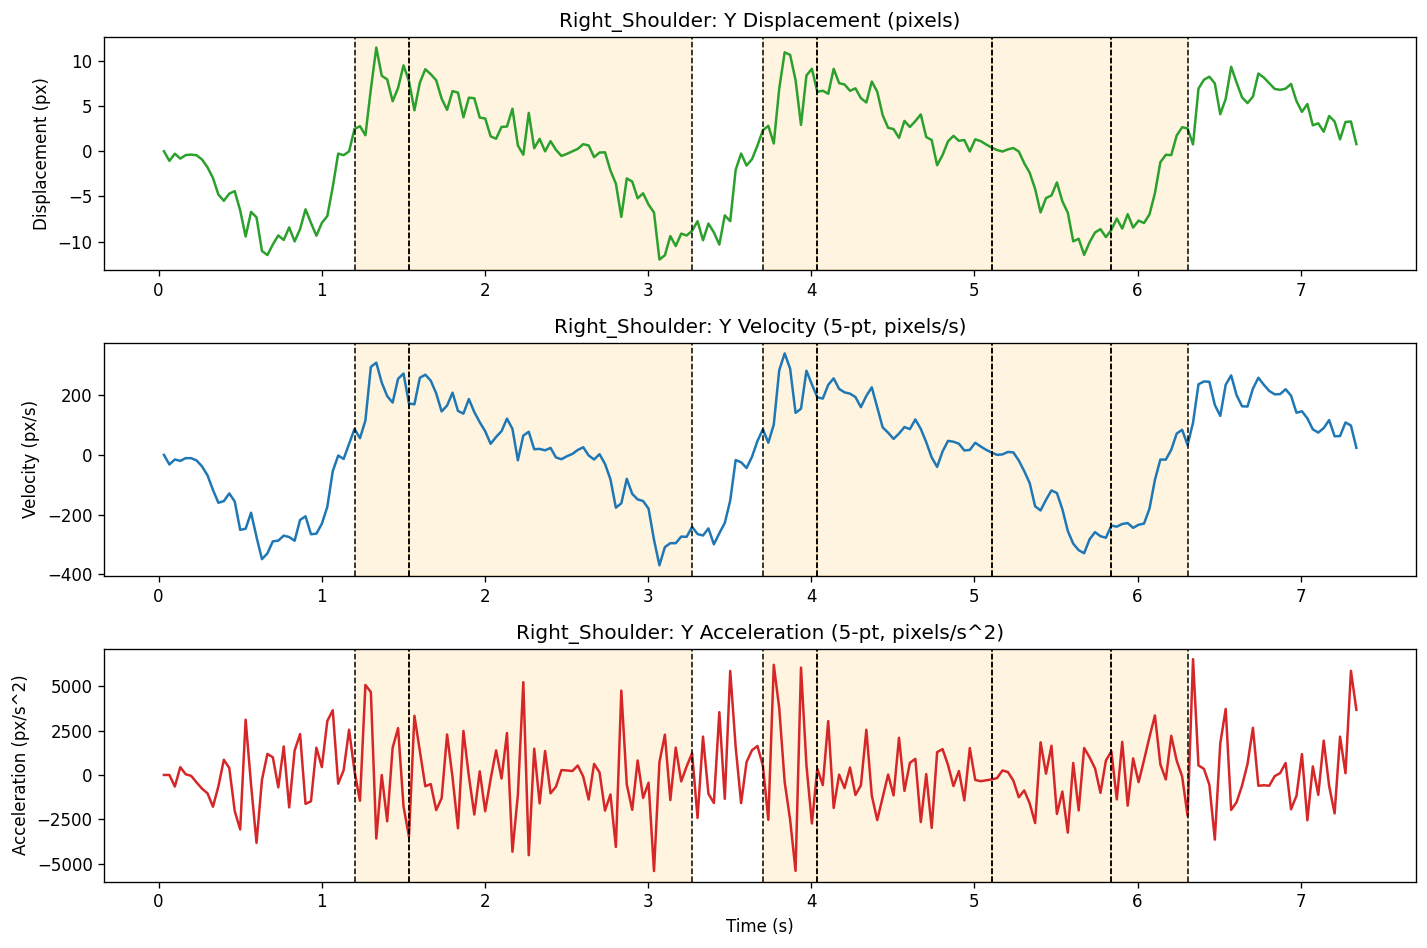

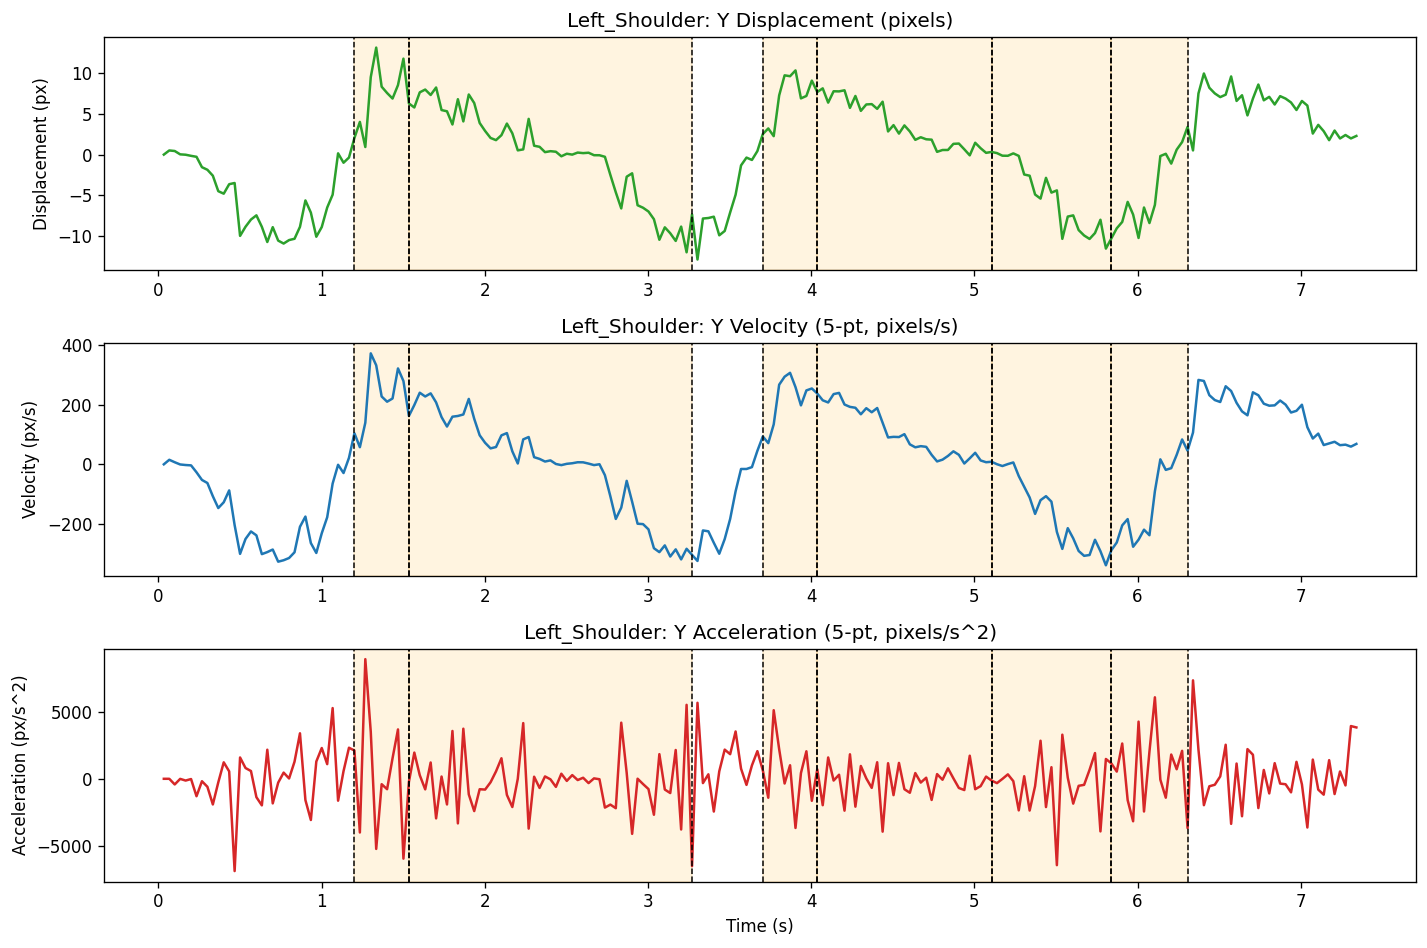

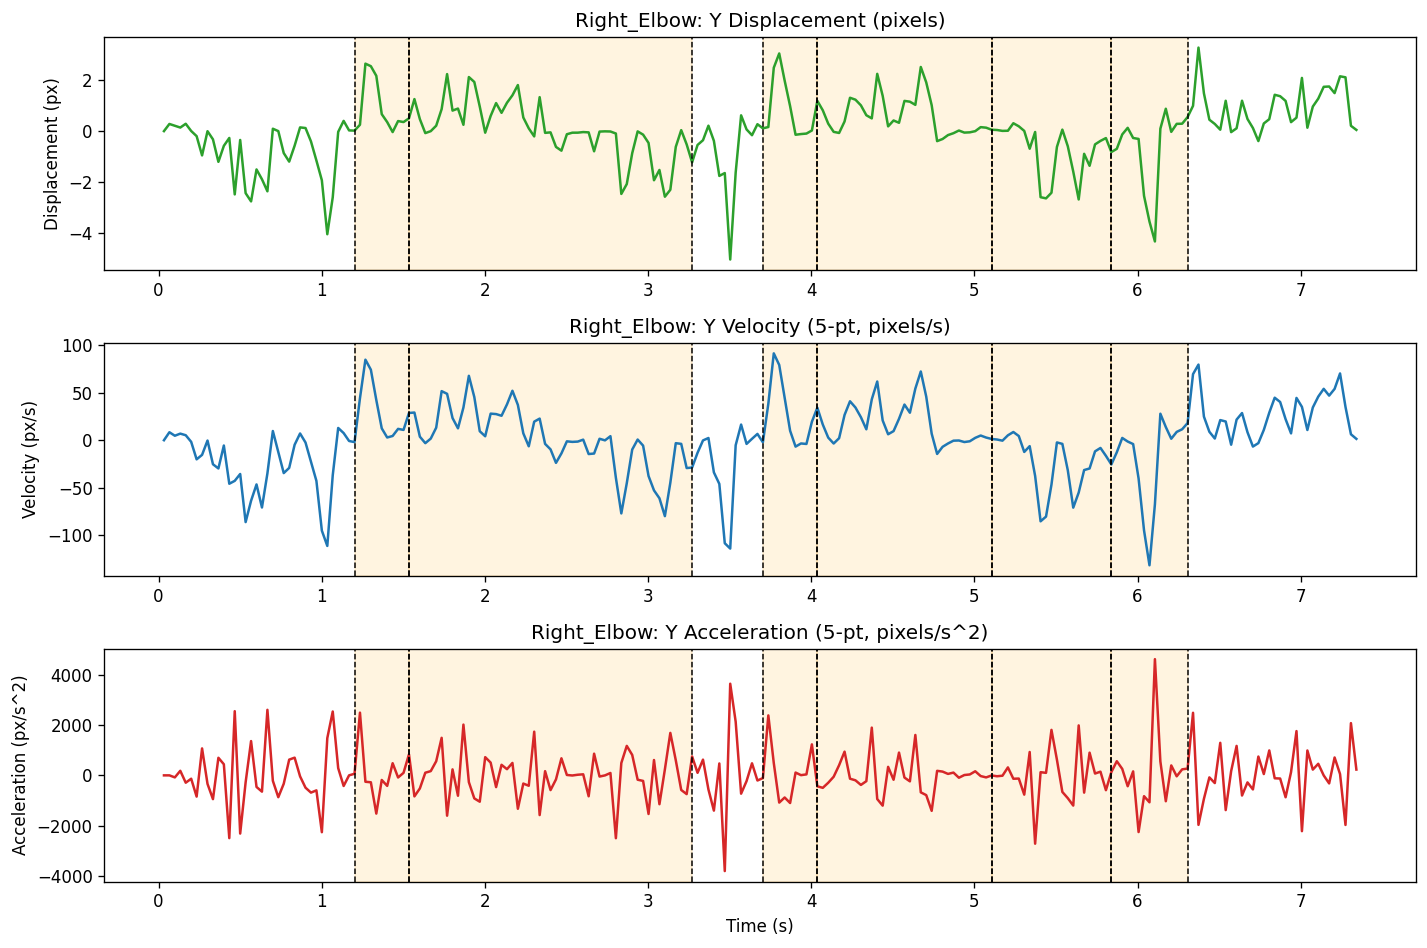

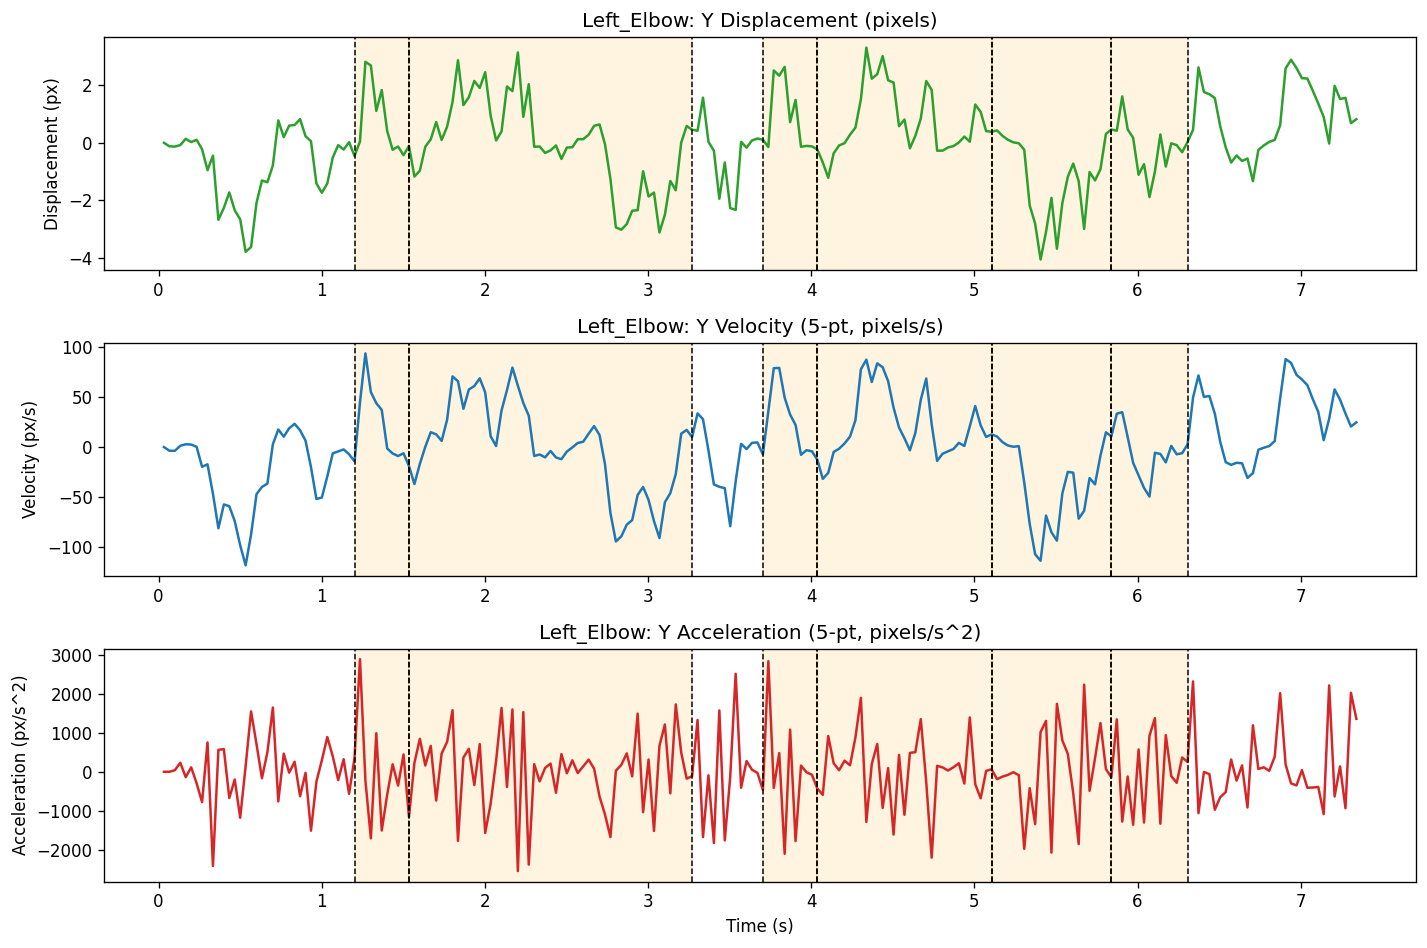

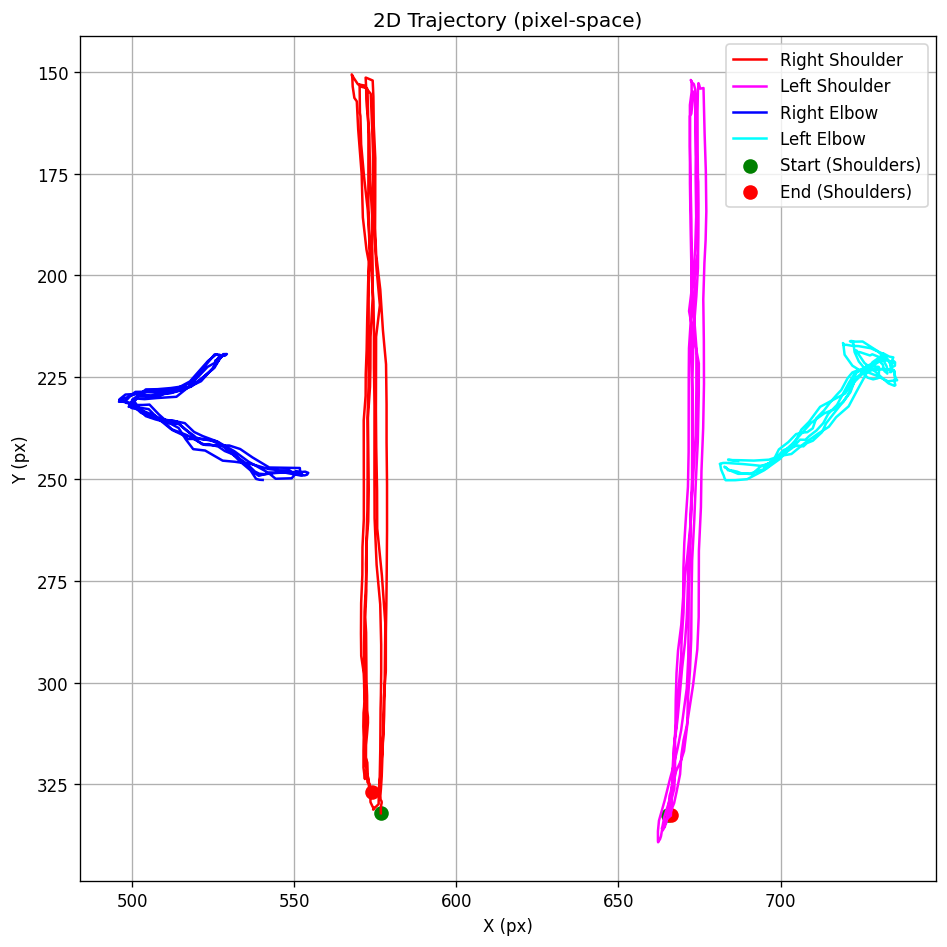

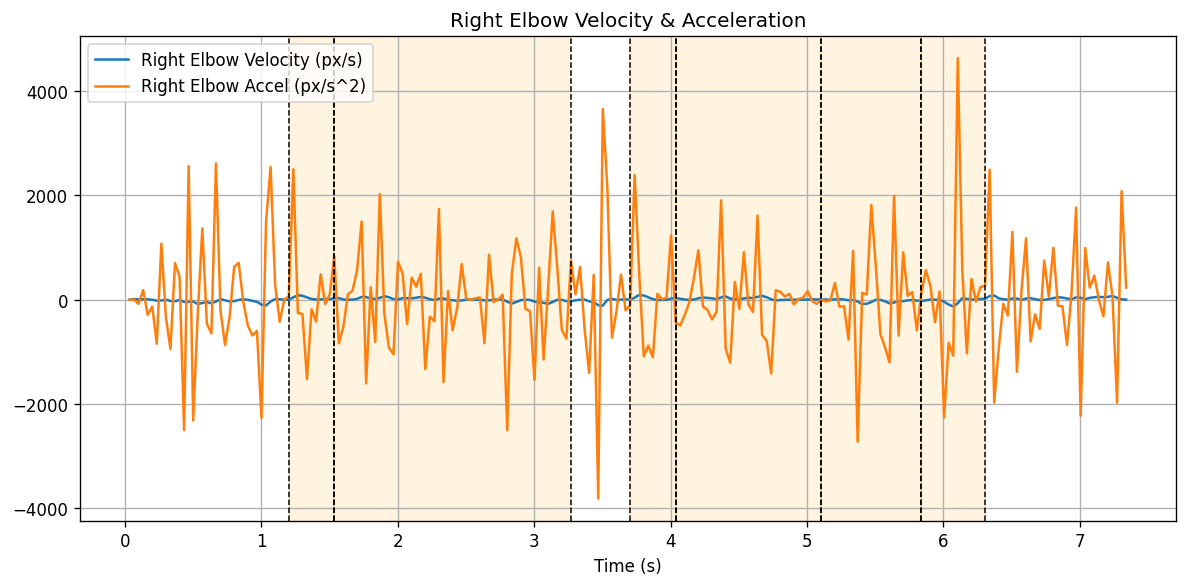

Detected reps:


,rep_id,start_frame,end_frame,start_time_s,end_time_s,duration_s,elbow_rom_deg,peak_velocity_px_s,peak_acceleration_px_s2
0,1,36,46,1.201200,1.534867,0.333667,-3.255068,84.743550,2501.176684
1,2,46,98,1.534867,3.269933,1.735067,100.968366,79.857213,2506.603735
2,3,111,121,3.703700,4.037367,0.333667,-2.048713,91.367990,2391.524234
3,4,121,153,4.037367,5.105100,1.067733,80.166267,72.288132,1904.048490
4,5,153,175,5.105100,5.839167,0.734067,2.702182,85.298427,2725.548865
5,6,175,189,5.839167,6.306300,0.467133,40.623567,131.563772,4635.048498


⬇️ Downloading outputs...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# ============================
# Full Pull-Up Analysis (Colab)
# - Keeps previous outputs intact
# - Adds pixel coordinates, time axis, rep segmentation, per-rep summary
# ============================

# If you see "ModuleNotFoundError", run:
# !pip install mediapipe opencv-python-headless pandas matplotlib scipy openpyxl

from google.colab import files
import cv2
import mediapipe as mp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.signal import savgol_filter, find_peaks

plt.rcParams["figure.dpi"] = 120

# --- UPLOAD VIDEO FILE ---
print("📂 Please upload your exercise video (e.g., pull_up_1.mp4):")
uploaded = files.upload()
VIDEO_PATH = list(uploaded.keys())[0]
print(f"✅ Using uploaded file: {VIDEO_PATH}")

# --- OUTPUT NAMES ---
base_name = os.path.splitext(VIDEO_PATH)[0]
OUTPUT_FULL_XLSX = f"{base_name}_full_data.xlsx"
OUTPUT_REP_XLSX = f"{base_name}_rep_summary.xlsx"

# --- POSE SETUP ---
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False,
                    min_detection_confidence=0.5,
                    min_tracking_confidence=0.5)

# --- HELPER: ANGLE ---
def calculate_angle(a, b, c):
    a, b, c = np.array(a), np.array(b), np.array(c)
    ba, bc = a - b, c - b
    denom = (np.linalg.norm(ba) * np.linalg.norm(bc))
    if denom == 0:
        return 0.0
    cosine_angle = np.dot(ba, bc) / denom
    angle = np.arccos(np.clip(cosine_angle, -1.0, 1.0))
    return float(np.degrees(angle))

# --- READ VIDEO + EXTRACT LANDMARKS (keep normalized AND add pixel coords) ---
cap = cv2.VideoCapture(VIDEO_PATH)
fps = cap.get(cv2.CAP_PROP_FPS) or 30.0
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)) or None
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)) or None

if width is None or height is None or width == 0 or height == 0:
    # Try reading a first frame to get size
    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
    ret, ftmp = cap.read()
    if ret:
        height, width = ftmp.shape[:2]

print(f"Detected FPS: {fps}, Frame size: {width}x{height}")

frame_num = 0
data = []

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    frame_num += 1
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = pose.process(rgb)

    if results.pose_landmarks:
        lmarks = results.pose_landmarks.landmark
        row = [frame_num]
        # store normalized coords (existing) and pixel coords (new)
        for i, lm in enumerate(lmarks):
            row.extend([lm.x, lm.y, lm.z])  # normalized (old)
            # pixel coordinates appended afterwards in df building (we'll compute later)
        # --- JOINT ANGLES (degrees) ---
        right_elbow_angle = calculate_angle(
            [lmarks[12].x, lmarks[12].y, lmarks[12].z],
            [lmarks[14].x, lmarks[14].y, lmarks[14].z],
            [lmarks[16].x, lmarks[16].y, lmarks[16].z]
        )
        left_elbow_angle = calculate_angle(
            [lmarks[11].x, lmarks[11].y, lmarks[11].z],
            [lmarks[13].x, lmarks[13].y, lmarks[13].z],
            [lmarks[15].x, lmarks[15].y, lmarks[15].z]
        )
        right_shoulder_angle = calculate_angle(
            [lmarks[24].x, lmarks[24].y, lmarks[24].z],
            [lmarks[12].x, lmarks[12].y, lmarks[12].z],
            [lmarks[14].x, lmarks[14].y, lmarks[14].z]
        )
        left_shoulder_angle = calculate_angle(
            [lmarks[23].x, lmarks[23].y, lmarks[23].z],
            [lmarks[11].x, lmarks[11].y, lmarks[11].z],
            [lmarks[13].x, lmarks[13].y, lmarks[13].z]
        )
        row.extend([right_elbow_angle, left_elbow_angle, right_shoulder_angle, left_shoulder_angle])
        data.append(row)

cap.release()
pose.close()

# --- BUILD DATAFRAME: normalized coords as before, plus angle columns ---
columns = ['frame']
for i in range(33):
    columns += [f'lm{i}_x', f'lm{i}_y', f'lm{i}_z']  # normalized (existing names)
columns += ['right_elbow_angle', 'left_elbow_angle', 'right_shoulder_angle', 'left_shoulder_angle']
df = pd.DataFrame(data, columns=columns)

# --- ADD PIXEL COORDS COLUMNS (lm{i}_x_px, lm{i}_y_px) ---
for i in range(33):
    df[f'lm{i}_x_px'] = df[f'lm{i}_x'] * width
    df[f'lm{i}_y_px'] = df[f'lm{i}_y'] * height

# --- TIME AXIS (seconds) ---
df['time_s'] = df['frame'] / fps

# --- SWAP CORRECTION (optional; keep existing logic) ---
def correct_symmetric_swaps(df, left_idx, right_idx, prefix='lm'):
    for idx in range(1, len(df)):
        prev_r = np.array([df.loc[idx-1, f'{prefix}{right_idx}_x'],
                           df.loc[idx-1, f'{prefix}{right_idx}_y']])
        prev_l = np.array([df.loc[idx-1, f'{prefix}{left_idx}_x'],
                           df.loc[idx-1, f'{prefix}{left_idx}_y']])
        curr_r = np.array([df.loc[idx, f'{prefix}{right_idx}_x'],
                           df.loc[idx, f'{prefix}{right_idx}_y']])
        curr_l = np.array([df.loc[idx, f'{prefix}{left_idx}_x'],
                           df.loc[idx, f'{prefix}{left_idx}_y']])
        d_rr = np.linalg.norm(curr_r - prev_r)
        d_rl = np.linalg.norm(curr_l - prev_r)
        d_ll = np.linalg.norm(curr_l - prev_l)
        d_lr = np.linalg.norm(curr_r - prev_l)
        if d_rl < d_rr and d_lr < d_ll:
            for axis in ['x', 'y']:
                temp = df.loc[idx, f'{prefix}{right_idx}_{axis}']
                df.loc[idx, f'{prefix}{right_idx}_{axis}'] = df.loc[idx, f'{prefix}{left_idx}_{axis}']
                df.loc[idx, f'{prefix}{left_idx}_{axis}'] = temp

# Apply swap correction on normalized coords (so pixel coords still consistent because derived earlier)
correct_symmetric_swaps(df, left_idx=13, right_idx=14, prefix='lm')  # elbows
correct_symmetric_swaps(df, left_idx=11, right_idx=12, prefix='lm')  # shoulders

# If swap corrected, recompute pixel coords to match (overwrite pixel columns)
for i in range(33):
    df[f'lm{i}_x_px'] = df[f'lm{i}_x'] * width
    df[f'lm{i}_y_px'] = df[f'lm{i}_y'] * height

# --- KINEMATICS (PIXEL-SPACE) ---
# We'll compute displacement (pixel diff), velocity (pixels/s) and acceleration (pixels/s^2)
h = 1.0 / fps
joints_px = {'lm12': 'Right_Shoulder', 'lm11': 'Left_Shoulder', 'lm14': 'Right_Elbow', 'lm13': 'Left_Elbow'}

for joint in joints_px.keys():
    y_col_px = f'{joint}_y_px'
    disp_col = f'{joint}_y_disp_px'
    vel_col = f'{joint}_y_v_px'
    acc_col = f'{joint}_y_a_px'

    # displacement (frame-to-frame in pixels)
    df[disp_col] = df[y_col_px].diff().fillna(0)

    # 5-point central difference for velocity: ( -f_{i+2} + 8 f_{i+1} - 8 f_{i-1} + f_{i-2} ) / (12*h)
    df[vel_col] = (
        -df[y_col_px].shift(-2) + 8 * df[y_col_px].shift(-1)
        - 8 * df[y_col_px].shift(1) + df[y_col_px].shift(2)
    ) / (12 * h)

    # 5-point stencil for acceleration:
    df[acc_col] = (
        -df[y_col_px].shift(-2) + 16 * df[y_col_px].shift(-1)
        - 30 * df[y_col_px] + 16 * df[y_col_px].shift(1)
        - df[y_col_px].shift(2)
    ) / (12 * h ** 2)

    # Edge fallback: replace NaNs with simple finite-difference approximations
    # velocity fallback: first-order diff / h
    df[vel_col] = df[vel_col].fillna(df[y_col_px].diff() / h).fillna(0)
    # acceleration fallback: second difference / h^2
    df[acc_col] = df[acc_col].fillna(df[y_col_px].diff(2) / (h ** 2)).fillna(0)

# --- Also keep normalized displacement/vel/acc (if you want) using normalized y coords (optional) ---
# (We'll compute them too so previous code outputs remain comparable)
for joint in joints_px.keys():
    y_col = f'{joint}_y'
    df[f'{joint}_y_disp'] = df[y_col].diff().fillna(0)
    df[f'{joint}_y_v'] = (
        -df[y_col].shift(-2) + 8 * df[y_col].shift(-1)
        - 8 * df[y_col].shift(1) + df[y_col].shift(2)
    ) / (12 * h)
    df[f'{joint}_y_a'] = (
        -df[y_col].shift(-2) + 16 * df[y_col].shift(-1)
        - 30 * df[y_col] + 16 * df[y_col].shift(1)
        - df[y_col].shift(2)
    ) / (12 * h ** 2)
    df[f'{joint}_y_v'] = df[f'{joint}_y_v'].fillna(df[y_col].diff() / h).fillna(0)
    df[f'{joint}_y_a'] = df[f'{joint}_y_a'].fillna(df[y_col].diff(2) / (h ** 2)).fillna(0)

# --- REP SEGMENTATION (using smoothed right elbow angle by default) ---
angle_col = 'right_elbow_angle'
angle = df[angle_col].values
n = len(angle)
if n < 5:
    print("Warning: too few frames for rep detection.")
    rep_events = []
else:
    # Smooth with Savitzky-Golay (window must be odd and <= n)
    win = min(max(5, int(n/15) | 1), 51)  # heuristic: at least 5, up to 51
    if win % 2 == 0:
        win += 1
    try:
        smooth_angle = savgol_filter(angle, window_length=win, polyorder=2)
    except Exception:
        smooth_angle = angle.copy()

    # find peaks (max) and troughs (min)
    peak_idx, _ = find_peaks(smooth_angle, distance=int(fps*0.3))  # peaks separated by ~0.3s
    trough_idx, _ = find_peaks(-smooth_angle, distance=int(fps*0.3))

    # pair trough -> peak -> trough as one rep (common for pull-up: low->high->low)
    rep_events = []
    troughs = sorted(list(trough_idx))
    peaks = sorted(list(peak_idx))
    # iterate troughs and find next peak and next trough
    for i in range(len(troughs)-1):
        t0 = troughs[i]
        # find peak between t0 and next trough
        candidates = [p for p in peaks if p > t0 and p < troughs[i+1]]
        if len(candidates) == 0:
            continue
        p = candidates[np.argmax(smooth_angle[candidates])]  # choose highest local peak
        t1 = troughs[i+1]
        # Valid rep if p between t0 and t1
        if t0 < p < t1:
            rep_events.append({'start_idx': int(t0), 'peak_idx': int(p), 'end_idx': int(t1)})

# If nothing found, try fallback: pair consecutive peaks as reps (less ideal)
if len(rep_events) == 0 and len(peak_idx) >= 2:
    for i in range(len(peak_idx)-1):
        s = peak_idx[i]
        e = peak_idx[i+1]
        rep_events.append({'start_idx': int(s), 'peak_idx': int(peak_idx[i]), 'end_idx': int(e)})

# Build per-rep summary
rep_rows = []
for ridx, ev in enumerate(rep_events, start=1):
    s, p, e = ev['start_idx'], ev['peak_idx'], ev['end_idx']
    start_frame = int(df.loc[s, 'frame'])
    end_frame = int(df.loc[e, 'frame'])
    start_time = float(df.loc[s, 'time_s'])
    end_time = float(df.loc[e, 'time_s'])
    duration = end_time - start_time

    # ROM (range of motion) in degrees for elbow
    rom = float(df.loc[p, angle_col]) - float(df.loc[s, angle_col])

    # peak abs velocity/acceleration within rep for the right elbow (pixel-space)
    vel_series = df.loc[s:e, 'lm14_y_v_px'].abs()
    acc_series = df.loc[s:e, 'lm14_y_a_px'].abs()
    peak_v = float(vel_series.max()) if len(vel_series) > 0 else 0.0
    peak_a = float(acc_series.max()) if len(acc_series) > 0 else 0.0

    rep_rows.append({
        'rep_id': ridx,
        'start_frame': start_frame,
        'end_frame': end_frame,
        'start_time_s': start_time,
        'end_time_s': end_time,
        'duration_s': duration,
        'elbow_rom_deg': rom,
        'peak_velocity_px_s': peak_v,
        'peak_acceleration_px_s2': peak_a
    })

rep_summary_df = pd.DataFrame(rep_rows)

# --- SAVE FULL DATA + REP SUMMARY ---
df.to_excel(OUTPUT_FULL_XLSX, index=False)
rep_summary_df.to_excel(OUTPUT_REP_XLSX, index=False)
print(f"✅ Saved: {OUTPUT_FULL_XLSX} (frame-wise) and {OUTPUT_REP_XLSX} (per-rep summary)")

# --- PLOTS (angles, aligned kinematics, trajectories) ---
# Helper to draw rep bands + lines
def draw_rep_markers(ax, rep_summary, alpha=0.12, color='orange'):
    for _, r in rep_summary.iterrows():
        ax.axvline(r['start_time_s'], color='k', linestyle='--', linewidth=0.9)
        ax.axvline(r['end_time_s'], color='k', linestyle='--', linewidth=0.9)
        ax.axvspan(r['start_time_s'], r['end_time_s'], color=color, alpha=alpha)

# 1) Shoulder angles
plt.figure(figsize=(10,6))
plt.plot(df['time_s'], df['right_shoulder_angle'], label='Right Shoulder', color='orange')
plt.plot(df['time_s'], df['left_shoulder_angle'], label='Left Shoulder', color='purple')
plt.xlabel('Time (s)'); plt.ylabel('Angle (°)')
plt.title('Shoulder Angles Over Time'); plt.legend(); plt.grid()
if not rep_summary_df.empty:
    draw_rep_markers(plt.gca(), rep_summary_df)
plt.tight_layout(); plt.show()

# 2) Elbow angles
plt.figure(figsize=(10,6))
plt.plot(df['time_s'], df['right_elbow_angle'], label='Right Elbow', color='red')
plt.plot(df['time_s'], df['left_elbow_angle'], label='Left Elbow', color='blue')
plt.xlabel('Time (s)'); plt.ylabel('Angle (°)')
plt.title('Elbow Angles Over Time'); plt.legend(); plt.grid()
if not rep_summary_df.empty:
    draw_rep_markers(plt.gca(), rep_summary_df)
plt.tight_layout(); plt.show()

# 3) Aligned kinematics: displacement, velocity, acceleration (pixel-space) for each joint
for joint, name in joints_px.items():
    disp_col = f'{joint}_y_disp_px'
    vel_col = f'{joint}_y_v_px'
    acc_col = f'{joint}_y_a_px'

    plt.figure(figsize=(12,8))
    plt.subplot(3,1,1)
    plt.plot(df['time_s'], df[disp_col], color='tab:green')
    plt.ylabel('Displacement (px)')
    plt.title(f'{name}: Y Displacement (pixels)')
    if not rep_summary_df.empty:
        draw_rep_markers(plt.gca(), rep_summary_df)

    plt.subplot(3,1,2)
    plt.plot(df['time_s'], df[vel_col], color='tab:blue')
    plt.ylabel('Velocity (px/s)')
    plt.title(f'{name}: Y Velocity (5-pt, pixels/s)')
    if not rep_summary_df.empty:
        draw_rep_markers(plt.gca(), rep_summary_df)

    plt.subplot(3,1,3)
    plt.plot(df['time_s'], df[acc_col], color='tab:red')
    plt.xlabel('Time (s)'); plt.ylabel('Acceleration (px/s^2)')
    plt.title(f'{name}: Y Acceleration (5-pt, pixels/s^2)')
    if not rep_summary_df.empty:
        draw_rep_markers(plt.gca(), rep_summary_df)

    plt.tight_layout(); plt.show()

# 4) 2D Trajectory (Elbows & Shoulders) - pixel space
plt.figure(figsize=(8,8))
plt.plot(df['lm12_x_px'], df['lm12_y_px'], label='Right Shoulder', color='red')
plt.plot(df['lm11_x_px'], df['lm11_y_px'], label='Left Shoulder', color='magenta')
plt.plot(df['lm14_x_px'], df['lm14_y_px'], label='Right Elbow', color='blue')
plt.plot(df['lm13_x_px'], df['lm13_y_px'], label='Left Elbow', color='cyan')
plt.scatter([df['lm12_x_px'].iloc[0], df['lm11_x_px'].iloc[0]],
            [df['lm12_y_px'].iloc[0], df['lm11_y_px'].iloc[0]], color='green', s=60, label='Start (Shoulders)')
plt.scatter([df['lm12_x_px'].iloc[-1], df['lm11_x_px'].iloc[-1]],
            [df['lm12_y_px'].iloc[-1], df['lm11_y_px'].iloc[-1]], color='red', s=60, label='End (Shoulders)')
plt.gca().invert_yaxis()
plt.xlabel('X (px)'); plt.ylabel('Y (px)')
plt.title('2D Trajectory (pixel-space)'); plt.legend(); plt.grid(); plt.tight_layout(); plt.show()

# 5) Optionally plot right elbow velocity & acceleration with rep markers (zoom)
if 'lm14_y_v_px' in df.columns:
    plt.figure(figsize=(10,5))
    plt.plot(df['time_s'], df['lm14_y_v_px'], label='Right Elbow Velocity (px/s)')
    plt.plot(df['time_s'], df['lm14_y_a_px'], label='Right Elbow Accel (px/s^2)')
    plt.xlabel('Time (s)'); plt.legend(); plt.grid()
    if not rep_summary_df.empty:
        draw_rep_markers(plt.gca(), rep_summary_df)
    plt.title('Right Elbow Velocity & Acceleration'); plt.tight_layout(); plt.show()

# --- PRINT REP SUMMARY ---
if rep_summary_df.empty:
    print("No reps detected automatically. You can tune detection parameters or inspect the angle plot.")
else:
    print("Detected reps:")
    display(rep_summary_df)

# --- DOWNLOAD OUTPUTS ---
print("⬇️ Downloading outputs...")
files.download(OUTPUT_FULL_XLSX)
files.download(OUTPUT_REP_XLSX)


Filtering


1. **Take displacement signal** (like shoulder Y-motion over time).
   → this is the raw motion extracted from MediaPipe.

2. **Apply FFT** → converts signal from *time domain* → *frequency domain*.
   → shows which frequencies exist in the motion (like a spectrum).

3. **Find dominant frequency** → the peak in the FFT.
   → tells how fast the main movement happens (e.g., ~1 Hz for 1 rep/sec).

4. **Choose cutoff frequency** = 1.05 × dominant freq (5 % above main motion).
   → ensures real motion is kept, higher-frequency noise is removed.

5. **Design Butterworth low-pass filter** → smooth, no sharp edges, gradual roll-off.
   → lets slow meaningful motion pass, blocks fast jitter.

6. **Apply filter (filtfilt)** → forward + backward pass, zero phase shift.
   → output = smooth displacement signal, same timing.

7. **Recompute velocity & acceleration** from this clean displacement.
   → graphs now look physically correct and less noisy.


In [ ]:
!pip install mediapipe opencv-python-headless pandas matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 6.5 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of opencv-python-headless to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of opencv-contrib-python to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 53.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 MB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 108.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 10.6 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
  Attempting uninstall: numpy
    Found ex

Saving pull up_11.mp4 to pull up_11 (1).mp4


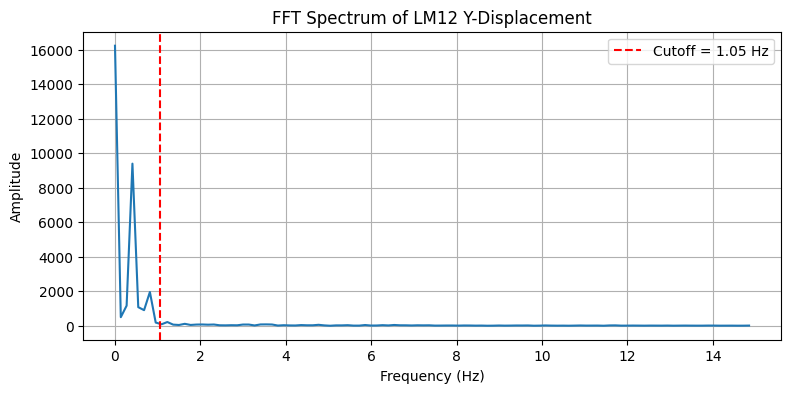

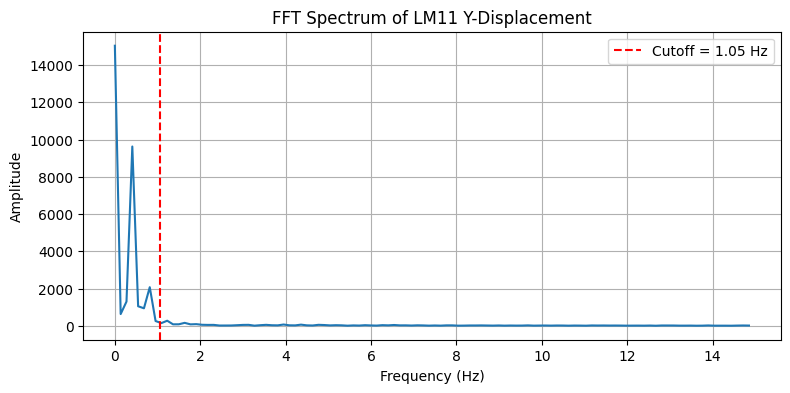

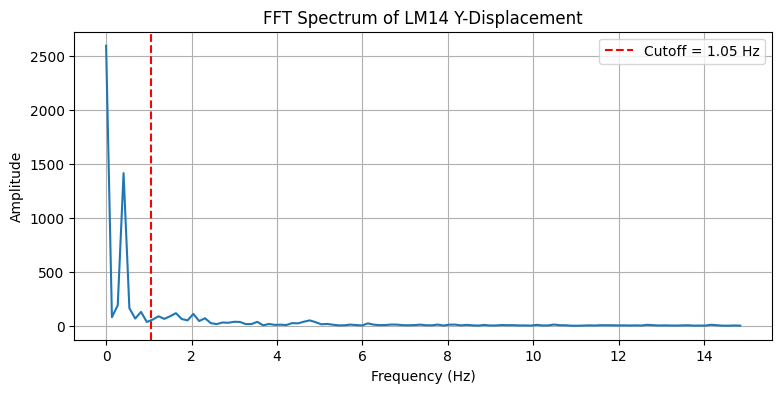

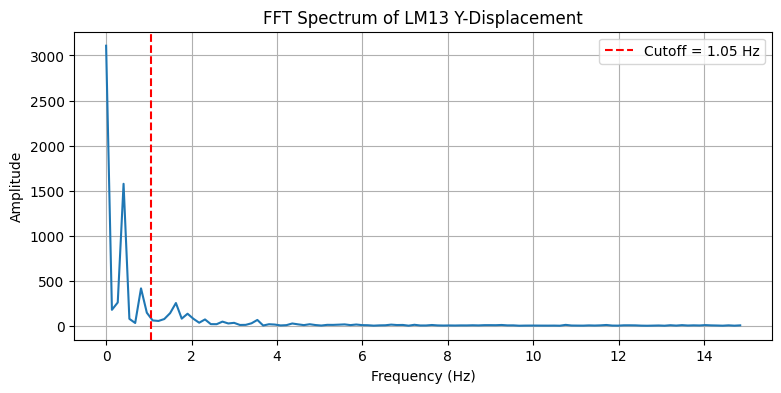

🏋️ Repetition Summary:
  Joint  Reps                                       Rep_Times(s)
0  lm12     3    [1.1344666666666667, 3.636966666666667, 6.2062]
1  lm11     3    [1.1344666666666667, 3.636966666666667, 6.2062]
2  lm14     3  [1.1344666666666667, 3.636966666666667, 6.2395...
3  lm13     3  [1.0010000000000001, 3.5368666666666666, 6.039...


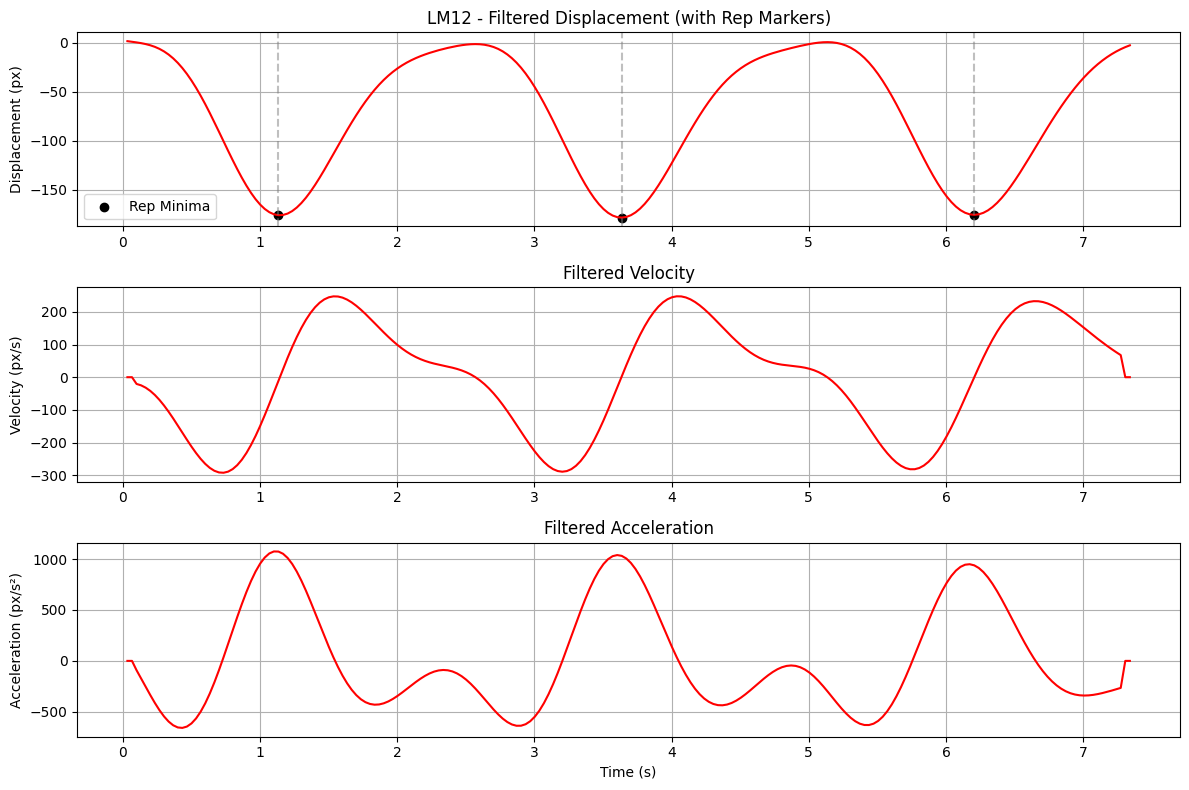

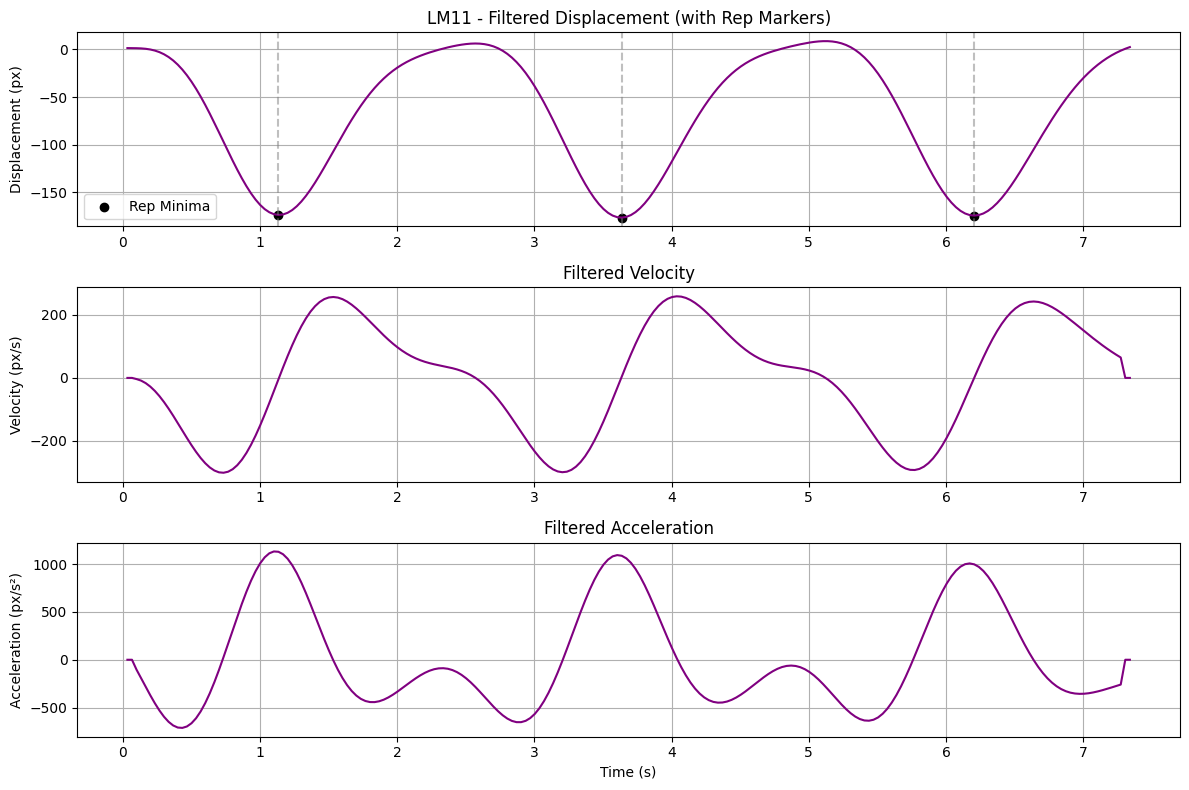

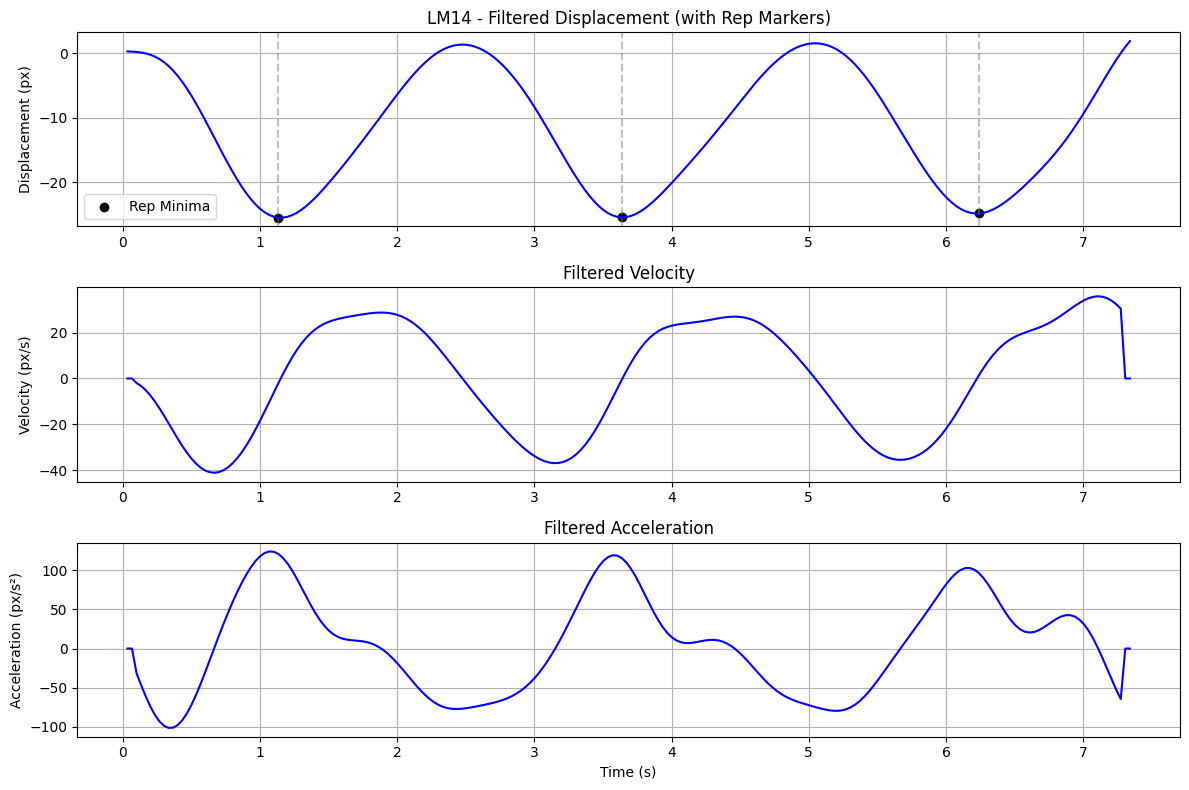

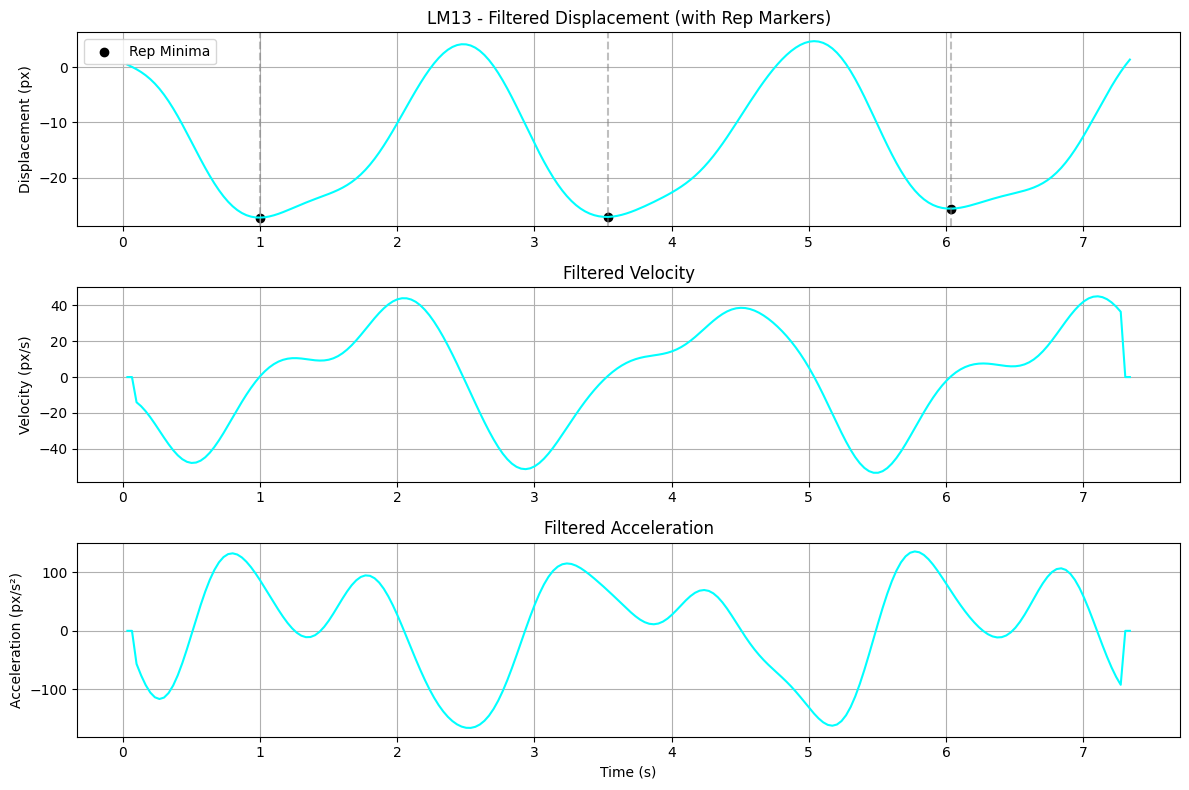

✅ All data + rep summary saved to 'kinematics_fft_filtered_with_reps.xlsx'


In [ ]:
# ==========================================
# 📘 Full Pose + FFT + Butterworth + Rep Segmentation
# ==========================================

from google.colab import files
import cv2, mediapipe as mp, numpy as np, pandas as pd, matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.signal import butter, filtfilt, find_peaks

# --- Upload video ---
uploaded = files.upload()
video_path = list(uploaded.keys())[0]

# --- Pose setup ---
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False,
                    min_detection_confidence=0.5,
                    min_tracking_confidence=0.5)

# --- Helper: angle calculation ---
def calculate_angle(a, b, c):
    a, b, c = np.array(a), np.array(b), np.array(c)
    ba, bc = a - b, c - b
    cos_ang = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    ang = np.arccos(np.clip(cos_ang, -1.0, 1.0))
    return np.degrees(ang)

# --- Data extraction ---
cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
width, height = cap.get(cv2.CAP_PROP_FRAME_WIDTH), cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
frame_num, data = 0, []

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    frame_num += 1
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    res = pose.process(rgb)
    if res.pose_landmarks:
        lmk = res.pose_landmarks.landmark
        row = [frame_num]
        for lm in lmk:
            row.extend([lm.x * width, lm.y * height, lm.z])
        # Angles
        re = calculate_angle([lmk[12].x, lmk[12].y, lmk[12].z],
                             [lmk[14].x, lmk[14].y, lmk[14].z],
                             [lmk[16].x, lmk[16].y, lmk[16].z])
        le = calculate_angle([lmk[11].x, lmk[11].y, lmk[11].z],
                             [lmk[13].x, lmk[13].y, lmk[13].z],
                             [lmk[15].x, lmk[15].y, lmk[15].z])
        rs = calculate_angle([lmk[24].x, lmk[24].y, lmk[24].z],
                             [lmk[12].x, lmk[12].y, lmk[12].z],
                             [lmk[14].x, lmk[14].y, lmk[14].z])
        ls = calculate_angle([lmk[23].x, lmk[23].y, lmk[23].z],
                             [lmk[11].x, lmk[11].y, lmk[11].z],
                             [lmk[13].x, lmk[13].y, lmk[13].z])
        row.extend([re, le, rs, ls])
        data.append(row)

cap.release()
pose.close()

# --- DataFrame setup ---
cols = ['frame'] + [f'lm{i}_{axis}' for i in range(33) for axis in ['x', 'y', 'z']]
cols += ['right_elbow_angle', 'left_elbow_angle', 'right_shoulder_angle', 'left_shoulder_angle']
df = pd.DataFrame(data, columns=cols)
df['time_s'] = df['frame'] / fps

# --- Kinematics (displacement / velocity / acceleration) ---
h = 1.0 / fps
for j in ['lm12', 'lm11', 'lm14', 'lm13']:
    df[f'{j}_y_disp'] = df[f'{j}_y'] - df[f'{j}_y'].iloc[0]
    df[f'{j}_y_v'] = (-df[f'{j}_y'].shift(-2) + 8*df[f'{j}_y'].shift(-1)
                      -8*df[f'{j}_y'].shift(1) + df[f'{j}_y'].shift(2)) / (12*h)
    df[f'{j}_y_a'] = (-df[f'{j}_y'].shift(-2) + 16*df[f'{j}_y'].shift(-1)
                      -30*df[f'{j}_y'] + 16*df[f'{j}_y'].shift(1)
                      -df[f'{j}_y'].shift(2)) / (12*h**2)
df.fillna(0, inplace=True)

# --- Butterworth filtering function ---
def butterworth_lowpass(signal, fs, cutoff_ratio=0.05, order=4):
    N = len(signal)
    freqs = fftfreq(N, 1/fs)
    fft_vals = np.abs(fft(signal))

    # avoid NaN or zero divisions
    if N < 4 or np.allclose(fft_vals, 0):
        return signal, freqs[:N//2], fft_vals[:N//2], 1.0

    # get dominant frequency safely
    max_freq = abs(freqs[np.argmax(fft_vals[:N//2])])
    if np.isnan(max_freq) or max_freq <= 0:
        max_freq = 1.0  # default 1 Hz if no motion detected

    # compute cutoff and clamp safely
    cutoff = max(1.0, min(max_freq * (1 + cutoff_ratio), fs / 2 * 0.9))

    b, a = butter(order, cutoff / (fs / 2), btype='low', analog=False)
    filtered = filtfilt(b, a, signal)
    return filtered, freqs[:N//2], fft_vals[:N//2], cutoff


# --- Apply FFT + filtering ---
for joint in ['lm12', 'lm11', 'lm14', 'lm13']:
    y = df[f'{joint}_y_disp'].values
    filtered, freqs, fft_vals, cutoff = butterworth_lowpass(y, fps, cutoff_ratio=0.05)
    df[f'{joint}_y_disp_filt'] = filtered

    # FFT plot
    plt.figure(figsize=(9,4))
    plt.plot(freqs, fft_vals)
    plt.axvline(cutoff, color='r', linestyle='--', label=f'Cutoff = {cutoff:.2f} Hz')
    plt.title(f"FFT Spectrum of {joint.upper()} Y-Displacement")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude")
    plt.legend(); plt.grid(); plt.show()

# --- Recompute velocity & acceleration from filtered disp ---
for j in ['lm12', 'lm11', 'lm14', 'lm13']:
    df[f'{j}_y_v_filt'] = (-df[f'{j}_y_disp_filt'].shift(-2) + 8*df[f'{j}_y_disp_filt'].shift(-1)
                            -8*df[f'{j}_y_disp_filt'].shift(1) + df[f'{j}_y_disp_filt'].shift(2)) / (12*h)
    df[f'{j}_y_a_filt'] = (-df[f'{j}_y_disp_filt'].shift(-2) + 16*df[f'{j}_y_disp_filt'].shift(-1)
                            -30*df[f'{j}_y_disp_filt'] + 16*df[f'{j}_y_disp_filt'].shift(1)
                            -df[f'{j}_y_disp_filt'].shift(2)) / (12*h**2)
df.fillna(0, inplace=True)

# --- Rep segmentation using peaks on filtered displacement ---
rep_summary = []
for joint in ['lm12', 'lm11', 'lm14', 'lm13']:
    sig = df[f'{joint}_y_disp_filt']
    peaks, _ = find_peaks(-sig, distance=fps*0.5, prominence=np.std(sig)*0.3)
    rep_count = len(peaks)
    rep_times = df['time_s'].iloc[peaks].values
    rep_summary.append({'Joint': joint, 'Reps': rep_count, 'Rep_Times(s)': rep_times})

rep_summary_df = pd.DataFrame(rep_summary)
print("🏋️ Repetition Summary:")
print(rep_summary_df)

# --- Plot filtered results with rep markings ---
def plot_filtered(df, joint, color):
    t = df['time_s']
    plt.figure(figsize=(12,8))
    plt.subplot(3,1,1)
    plt.plot(t, df[f'{joint}_y_disp_filt'], color=color)
    plt.title(f"{joint.upper()} - Filtered Displacement (with Rep Markers)")
    plt.ylabel("Displacement (px)")
    peaks, _ = find_peaks(-df[f'{joint}_y_disp_filt'], distance=fps*0.5, prominence=np.std(df[f'{joint}_y_disp_filt'])*0.3)
    plt.scatter(df['time_s'].iloc[peaks], df[f'{joint}_y_disp_filt'].iloc[peaks],
                color='black', label='Rep Minima')
    for p in peaks:
        plt.axvline(df['time_s'].iloc[p], color='gray', linestyle='--', alpha=0.5)
    plt.legend(); plt.grid()

    plt.subplot(3,1,2)
    plt.plot(t, df[f'{joint}_y_v_filt'], color=color)
    plt.ylabel("Velocity (px/s)")
    plt.title("Filtered Velocity")
    plt.grid()

    plt.subplot(3,1,3)
    plt.plot(t, df[f'{joint}_y_a_filt'], color=color)
    plt.xlabel("Time (s)")
    plt.ylabel("Acceleration (px/s²)")
    plt.title("Filtered Acceleration")
    plt.grid()
    plt.tight_layout()
    plt.show()

for j,c in zip(['lm12','lm11','lm14','lm13'],['red','purple','blue','cyan']):
    plot_filtered(df, j, c)

# --- Save to Excel ---
output_name = "kinematics_fft_filtered_with_reps.xlsx"
with pd.ExcelWriter(output_name) as writer:
    df.to_excel(writer, sheet_name='Full Data', index=False)
    rep_summary_df.to_excel(writer, sheet_name='Repetition Summary', index=False)
print(f"✅ All data + rep summary saved to '{output_name}'")
